In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
import paf_loader
from os.path import join, isdir, isfile
import numpy as np
import cv2
from cselect import color as cs
from time import time
from reid import reid

from mvpose.data import umpm
from mvpose.algorithm.settings import get_settings, get_tracking_settings

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

_start = time()
X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

# --- Things that kinda have to be parametrized ---
candidate_main_name = 'umpm_ms60_candidates_frame'
dict_file = join(tmp, 'scores_s60_umpm_overfit.npy')
params = get_settings(ms_radius=60)
dict_file = join(tmp, 'scores_s60.npy')
# -------------------------------------------------

_start = time()

#reid_model = reid.ReId(
#    url='http://188.138.127.15:81/models/model_heavy_umpm.h5',
#    name='model_heavy_umpm.h5')
reid_model = {}  # we can skip this ONLY if we already calc. reid scores!
tracking_params = get_tracking_settings(params, 
                                        low_spec_mode=True, 
                                        reid_model=reid_model,
                                        personreid_batchsize=2)
_end = time()
print("loading settings:", _end - _start)
def get_track(FRAMES):
    Ims = []
    Hms = []
    Pafs = []
    
    im_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'im.npy'
    hm_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'hm.npy'
    pf_name = 'umpm_f' + '_'.join([str(s) for s in FRAMES]) + 'pf.npy'
    im_name = join(tmp, im_name)
    hm_name = join(tmp, hm_name)
    pf_name = join(tmp, pf_name)
    
    if isfile(im_name) and isfile(hm_name) and isfile(pf_name):
        Ims = np.load(im_name)
        Hms = np.load(hm_name)
        Pafs = np.load(pf_name)
    else:
        for frame in FRAMES:
            print('load frame ', frame)
            Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
            Ims.append(Im)
            heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
                                                                Im, 
                                                                frame, 
                                                                dir=tmp)
            Hms.append(heatmaps)
            Pafs.append(pafs)

        Ims = np.array(Ims)
        Hms = np.array(Hms)
        Pafs = np.array(Pafs)
        np.save(im_name, Ims)
        np.save(hm_name, Hms)
        np.save(pf_name, Pafs)
        
    return Ims, Hms, Pafs

X[0].shape

/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
loading settings: 0.0005247592926025391


(2437, 486, 644, 3)

# Step 1: pre-load pafs and heatmaps
(my laptop 'sucks' so I need to pre-load the pafs and heatmaps)

In [ ]:
# def load(FRAMES):
#     for frame in FRAMES:
#         print('handle frame ', frame)
#         Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
#         heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
#                                                             Im, 
#                                                             frame, 
#                                                             dir=tmp)
#         del heatmaps
#         del pafs
#         del Im

# def qq():
#     for i in range(2270, 2500, 60):
#         FRAMES = list(range(i, i+60, 30))
#         print('frames:', FRAMES)
#         _start = time()
#         load(FRAMES)
#         _end = time()
#         print('\telapsed', _end - _start)

# qq()  # "memory-efficient" way of loading the data 

# Step 2: generate candidates

In [ ]:
# from mvpose import pose
# from mvpose.algorithm import graphcut

# def execute(FRAME):

#     Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

#     print('\nframe:', FRAME)
#     heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
#                                                             Im, 
#                                                             FRAME, 
#                                                             dir=tmp)
#     _start = time()
#     detections = pose.estimate_heuristic(
#         Calib, heatmaps, pafs, settings=params, 
#         debug=True, use_greedy=False)
#     _end = time()
#     print('total elapsed:', _end - _start)
    
#     # -- store to file --
#     #candidate_name = candidate_main_name + str(FRAME) + ".npy"
#     #candidate_name = join(tmp, candidate_name)
#     #np.save(candidate_name, detections)
    
#     del heatmaps
#     del pafs
#     del detections

# def run_all():
#     # go to 2500
#     for i in range(0, 2500, 60):
#         FRAMES = list(range(i, i+60, 30))
#         for f in FRAMES:
#             execute(f)

# run_all()



# Step 3: calculate re-id score

In [2]:
from mvpose.algorithm.track_graph_partitioning import get_bb, distance3d_humans, ValidImageCandidateExtractor
from mvpose.tracking import extend_calibration_to_frames

n_frames = 2437
graph_3d = {}
human_candidates = []
Im = []
for frame in range(0, n_frames, 30):
    if frame % 300 == 0:
        print('frame ', frame)
    candidate_name = candidate_main_name + str(frame) + ".npy"
    candidate_name = join(tmp, candidate_name)
    assert isfile(candidate_name)
    Humans = np.load(candidate_name)
    human_candidates.append(Humans)
    im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]], 'uint8')
    Im.append(im)
Im = np.array(Im, 'uint8')

print(len(human_candidates))

Calibs = extend_calibration_to_frames([Calib], n_frames)

img_cand = ValidImageCandidateExtractor(
    Im, human_candidates, Calibs, tracking_params)


# ---------------------------------------------------

# n = len(img_cand.ImgsA)
# start = 0
# if isfile(dict_file):
#     start = np.load(dict_file).item()['next_frame']

# print('start:' + str(start) + ' until ' + str(n))
# for frame in range(start, n):
#     if isfile(dict_file):
#         storage = np.load(dict_file).item()
#     else:
#         storage = {}
    
#     if frame % 10 == 0:
#         print('frame %05d/' % (frame+1) + str(n))
#         _start = time()
#     A = img_cand.ImgsA[frame]
#     B = img_cand.ImgsB[frame]
#     score = np.squeeze(reid_model.predict(A, B))
#     #print('storage', storage)
#     #print('score', score)
#     storage[frame] = score
#     storage['next_frame'] = frame + 1
#     np.save(dict_file, storage)
#     if frame % 10 == 0:
#         _end = time()
#         print('\telapsed', _end - _start)
#     del storage
    

frame  0
frame  300
frame  600
frame  900
frame  1200
frame  1500
frame  1800
frame  2100
frame  2400
82


# Step 4: build graph

In [3]:
from mvpose.algorithm.track_graph_partitioning import generate_graph3d, generate_graph3d_max, GraphSolver
from mvpose.algorithm.track_graph_partitioning import construct_query_graph
from mvpose.tracking import extract_tracks

storage = np.load(dict_file).item()

scores = []
pairs = img_cand.pairs
n = len(img_cand.ImgsA)
print(n)

assert(len(pairs) == n)
for frame in range(n):
    scores.append(storage[frame])
assert len(scores) == n


graph_3d = generate_graph3d_max(scores, pairs)  # t1, pid1, t2, pid2

n_frames_red = len(human_candidates)
graph_partitioning = GraphSolver(graph_3d, 
                                 n_frames_red,
                                 tracking_params.T)


G = construct_query_graph(graph_partitioning, n_frames_red)

tracks = extract_tracks(human_candidates, G)

15638
[graph partitioning]
	solve graph with 1197 edges...


# Step 5: Evaluation

In [17]:
import numpy as np
from pak.evaluation import MOTA

from mvpose.tracking import extract_tracks

tracks = extract_tracks(human_candidates, G)

# right food: own dataset: 13, mscoco: 10
# left foot: own dataset 10, mscoco: 13

# -- pairs --
# GT    HY    Name
# ----------------
# 13    10    right foot
# 12     9    right knee
# 11     8    right hip
# 10    13    left foot
#  9    12    left knee
#  8    11    left hip
#  7     4    right hand
#  6     3    right elbow
#  5     2    right shoulder
#  4     7    left hand
#  3     6    left elbow
#  2     5    left shoulder

GT_jid = 2  # 0 ... 13
HY_jid = 5  # 0 ... 17

Gt = []
Hy = []
for loc_frame, frame in enumerate(range(0, n_frames, 30)):
    # === ground truth ===
    y = Y[frame]
    pid1 = 0
    p1 = y[GT_jid, 0:3]
    pid2 = 1
    p2 = y[GT_jid+14, 0:3]
    Gt.append((loc_frame, pid1, *p1))
    Gt.append((loc_frame, pid2, *p2))
    
    # === hypothesis ===
    for loc, human in enumerate(human_candidates[loc_frame]):
        pt = human[HY_jid]
        pid = tracks[loc_frame][loc]
        if pt is not None:
            Hy.append((loc_frame, pid, *pt))
    
    
# print(Hy)
# print('--')
# print(Gt)
Hy = np.array(Hy)
Gt = np.array(Gt)

threshold = 150
# result is a scalar value in the range of [-infinity, 1)
mota, info, debug = MOTA.evaluate(Gt, Hy, threshold, info=True, 
                           debug_info=True)

print('MOTA', mota)
print('info', info)

MOTA 0.9939024390243902
info {'FN': 0, 'FP': 1, 'IDSW': 0, 'GT': 164}


# Plot FP

In [ ]:
import numpy.linalg as la

FP_pairs = debug['FP']
n = len(FP_pairs)
print('n=', n)

colors = ['red', 'blue', 'green', 'yellow', 'lila']

fig = plt.figure(figsize=(16, 4 * n))

for idx, (frame, pid, x, y, z) in enumerate(FP_pairs):
    frame = int(frame)
    pid_hat = int(pid)
    p_est = np.array((x, y, z))
    
    # -- get real locations --
    real_frame = 30 * frame
    y = Y[real_frame]
    pid1 = 0
    p1 = y[GT_jid, 0:3]
    pid2 = 1
    p2 = y[GT_jid+14, 0:3]
    
    print('\nframe: ' + str(frame) + ', pid:' + str(pid_hat))
    print('\tdistance to pid0:', la.norm(p1 - p_est))
    print('\tdistance to pid1:', la.norm(p2 - p_est))
    
    for cid in range(1, 5):
        cam = Calib[cid-1]
        ax = fig.add_subplot(n, 4, (idx*4)+cid)
        ax.axis('off')
        ax.imshow(Im[frame][cid-1], alpha=0.3)
        
        pts2d = cam.projectPoints(np.array([p1, p2, p_est]))
        p1_2d, p2_2d, p_est_2d = pts2d
        ax.scatter(p1_2d[0], p1_2d[1], color=colors[0], marker='*', alpha=0.5)
        ax.scatter(p2_2d[0], p2_2d[1], color=colors[1], marker='*', alpha=0.5)
        ax.scatter(p_est_2d[0], p_est_2d[1], color=colors[pid_hat], marker='o', alpha=0.5)
        
    
plt.show()

In [ ]:
# fig = plt.figure(figsize=(16, 8))

# frame, pid, x, y, z = FP_pairs[0]
# frame = int(frame)
# pid_hat = int(pid)
# p_est = np.array((x, y, z))

# # -- get real locations --
# real_frame = 30 * frame
# y = Y[real_frame]
# pid1 = 0
# p1 = y[GT_jid, 0:3]
# pid2 = 1
# p2 = y[GT_jid+14, 0:3]

# print('\nframe: ' + str(frame) + ', pid:' + str(pid_hat))
# print('\tdistance to pid0:', la.norm(p1 - p_est))
# print('\tdistance to pid1:', la.norm(p2 - p_est))

# for cid in range(1, 5):
#     cam = Calib[cid-1]
#     ax = fig.add_subplot(1, 4, cid)
#     #ax.axis('off')
#     ax.imshow(Im[frame][cid-1], alpha=0.4)
    
#     if cid == 1:
#         ax.set_xlim([320, 420])
#         ax.set_ylim([200, 50])
#         ax.set_title('(a)', fontsize=16)
#     if cid == 2:
#         ax.set_xlim([400, 500])
#         ax.set_ylim([250, 100])
#         ax.set_title('(b)', fontsize=16)
#     if cid == 3:
#         ax.set_xlim([230, 330])
#         ax.set_ylim([200, 50])
#         ax.set_title('(c)', fontsize=16)
#     if cid == 4:
#         ax.set_xlim([50, 150])
#         ax.set_ylim([250, 100])
#         ax.set_title('(d)', fontsize=16)

#     pts2d = cam.projectPoints(np.array([p1, p2, p_est]))
#     p1_2d, p2_2d, p_est_2d = pts2d
#     ax.scatter(p1_2d[0], p1_2d[1], color='blue', marker='*', alpha=0.9)
#     #ax.scatter(p2_2d[0], p2_2d[1], color='blue', marker='*', alpha=0.9)
#     ax.scatter(p_est_2d[0], p_est_2d[1], color='red', marker='o', alpha=0.5)
        
    
# plt.show()

# Plot to images

In [ ]:
# from mvpose.algorithm.candidate_selection import project_human_to_2d
# from mvpose.plot.limbs import draw_mscoco_human
# output_loc = '/home/julian/Videos'

# frame = 0

# for frame in range(57, n_frames_red):
#     print('handle', frame)
#     colors = ['red', 'blue', 'green']

#     fname = join(output_loc, '%04d.png' % frame)

#     fig = plt.figure(figsize=(16, 12))

#     FRAME = frame * 30
#     Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
#     TR = tracks[frame]
#     HM = human_candidates[frame]

#     for idx, cam in enumerate(Calib):
#         ax = fig.add_subplot(2,2,1+idx)
#         ax.axis('off')
#         im = Im[idx]
#         h,w,_ = im.shape
#         ax.imshow(im, alpha=0.6)

#         for pid, human in enumerate(HM):
#             draw_mscoco_human(ax, human, cam, color=colors[TR[pid]])

#     plt.savefig(fname)
#     del fig
#     del Im
#     del TR
#     del HM

In [4]:
FRAME = 0

print('qq')
Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, 
                                                                FRAME, 
                                                                dir=tmp)


print('hello')


qq
hello


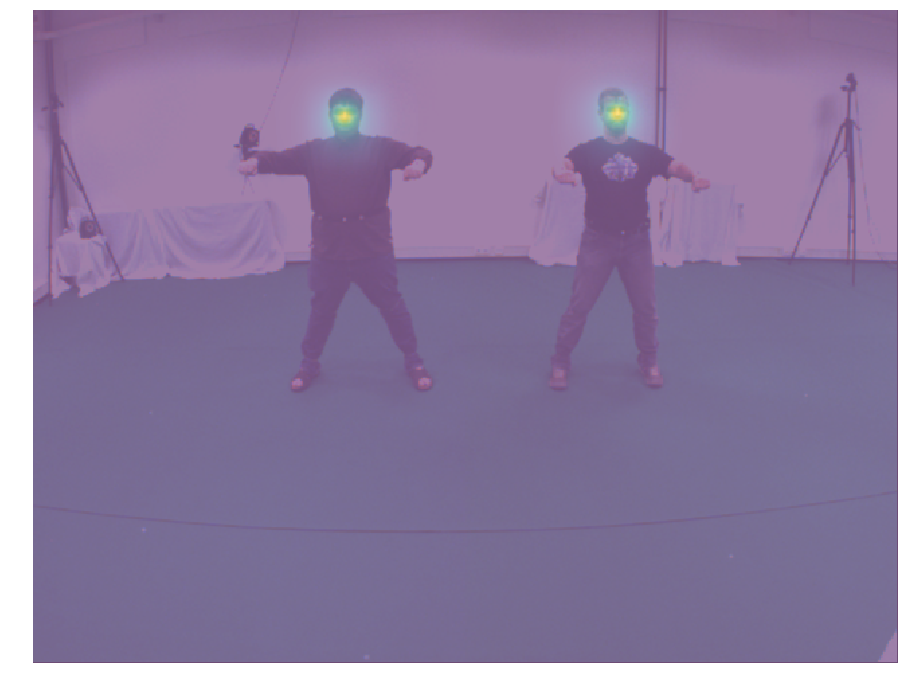

In [5]:
fig = plt.figure(figsize=(16,12))

cam = 3

ax = fig.add_subplot(111)
ax.imshow(Im[cam], alpha=0.4)
ax.imshow(heatmaps[cam,:,:,0], alpha=0.5)
ax.axis('off')
plt.show()

1.13164280965809


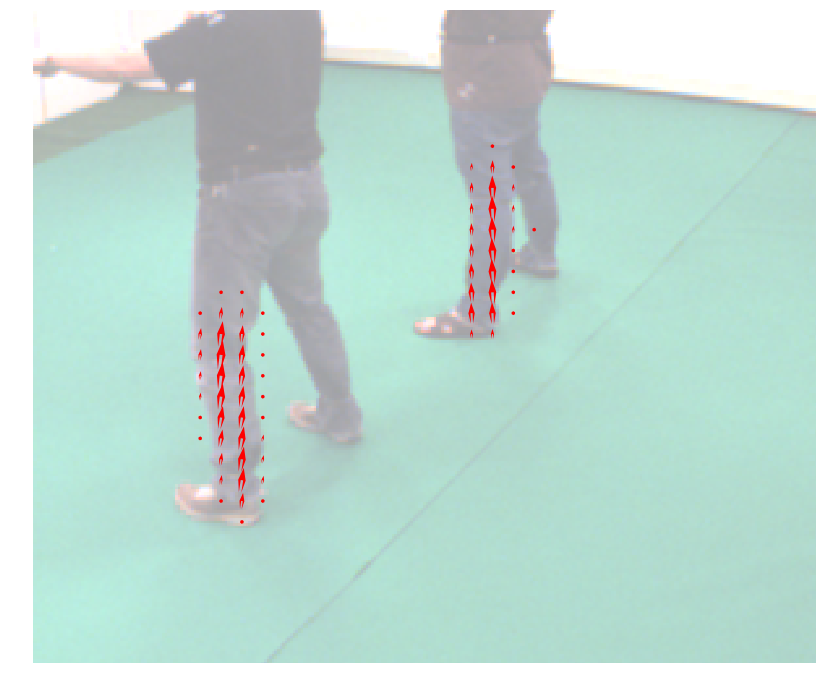

In [6]:
u, v = 10, 11

from math import sqrt 

paf = pafs[0]
U, V = paf[:,:, u],  paf[:,:, v]

h, w = U.shape

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
ax.set_xlim([200, 500])
ax.set_ylim([350, 100])

_X = []
_Y = []
_U = []
_V = []
SIZ = []

for x in range(0, w, 8):
    for y in range(0, h, 8):
        u = U[y,x]
        v = V[y,x]
        
        ss = sqrt(u**2 + v**2)
        
        if ss > 0.2:
            SIZ.append(ss)
            _X.append(x)
            _Y.append(y)
            _U.append(u)
            _V.append(v)
        

ax.imshow(Im[0], alpha=0.4)
ax.quiver(_X, _Y, _U, _V, scale=60, width=0.005, 
          headaxislength=10, alpha=1, color='red')


print(np.max(SIZ))
ax.axis('off')
plt.show()

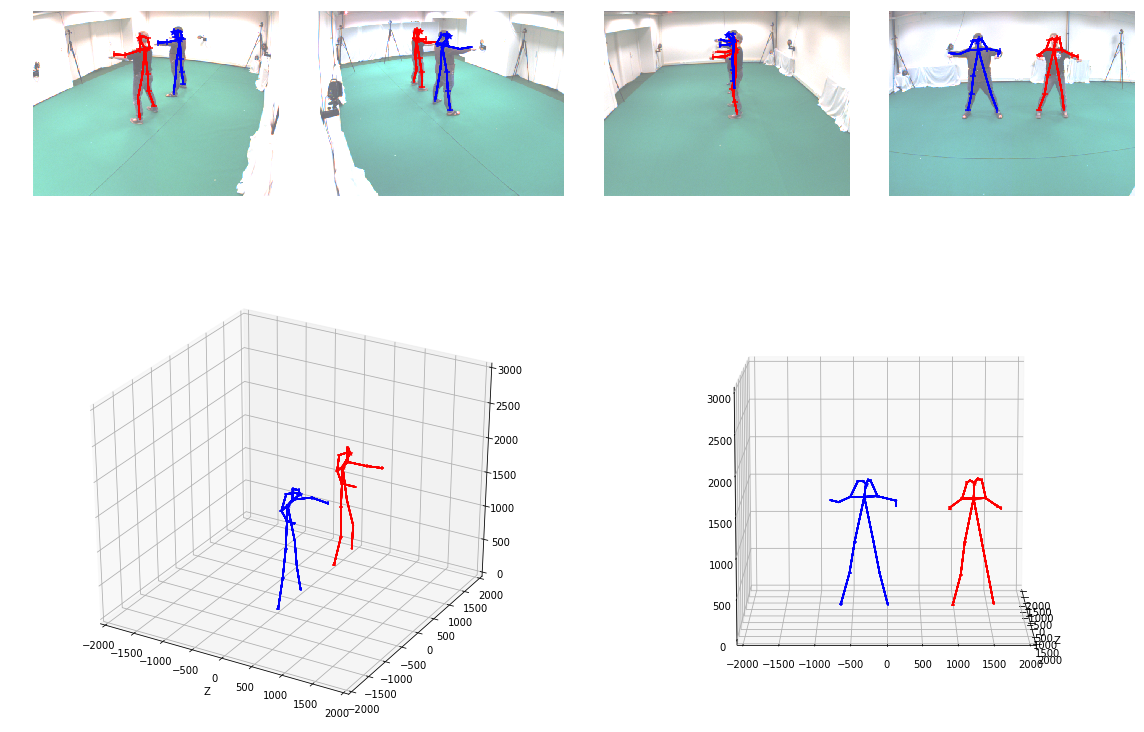

In [7]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human3d
from mpl_toolkits.mplot3d import Axes3D

FRAME = 0
candidate_name = candidate_main_name + str(FRAME) + ".npy"
candidate_name = join(tmp, candidate_name)
Humans = np.load(candidate_name)

cur_track = tracks[int(FRAME/30)]

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,4,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, 
                          color=colors[cur_track[pid]])
        
def setup3d(ax):
    ax.set_xlabel('X')
    ax.set_xlabel('Y')
    ax.set_xlabel('Z')
    ax.set_xlim([-2000, 2000])
    ax.set_ylim([-2000, 2000])
    ax.set_zlim([0, 3000])

ax = fig.add_subplot(2, 2, 3, projection='3d')
setup3d(ax)
for pid, human in enumerate(Humans):
    draw_mscoco_human3d(ax, human, 
                          color=colors[cur_track[pid]])


ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.view_init(elev=10., azim=0)
setup3d(ax)
for pid, human in enumerate(Humans):
    draw_mscoco_human3d(ax, human, 
                          color=colors[cur_track[pid]])
    
plt.tight_layout()
plt.show()

In [ ]:
a = np.array([2, 0])
b = np.array([1, 0])

a @ b

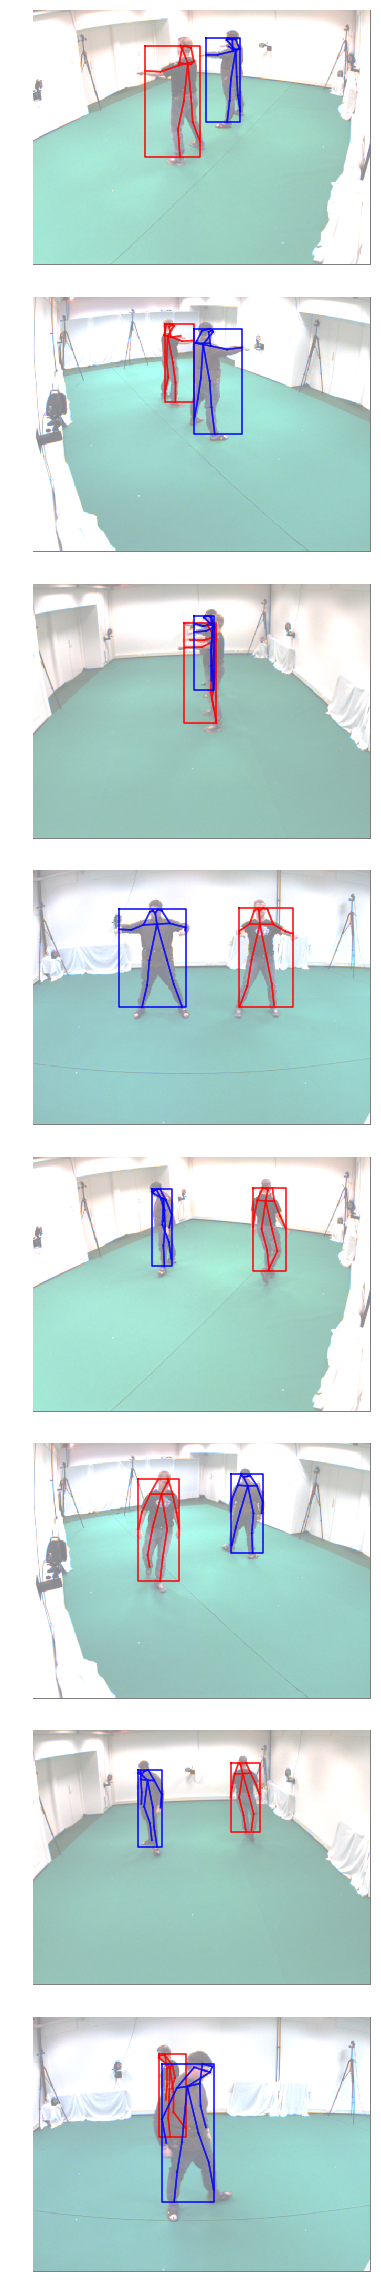

In [12]:
from mvpose.algorithm.track_graph_partitioning import get_bb

frame1 = 30
frame2 = 600

fig = plt.figure(figsize=(16,32))

for t, f in enumerate([frame1, frame2]):
    
    candidate_name = candidate_main_name + str(f) + ".npy"
    candidate_name = join(tmp, candidate_name)
    Humans = np.load(candidate_name)

    cur_track = tracks[int(f/30)]
    
    for cid, img in enumerate(X):
        ax = fig.add_subplot(8, 1, t*4 + (cid+1))
        ax.axis('off')
        ax.imshow(img[f], alpha=0.5)
        h,w,_ = img[f].shape
        
        cam = Calib[cid]
        for pid, human in enumerate(Humans):
            cur_color = colors[cur_track[pid]]
            draw_mscoco_human(ax, human, cam, color=cur_color, alpha=0.1)
            
            minx, miny, maxx, maxy = get_bb(cam, human, w,h)
            ax.plot([minx, minx, maxx, maxx, minx], [miny, maxy, maxy, miny, miny], color=cur_color)
            

plt.tight_layout()
plt.show()

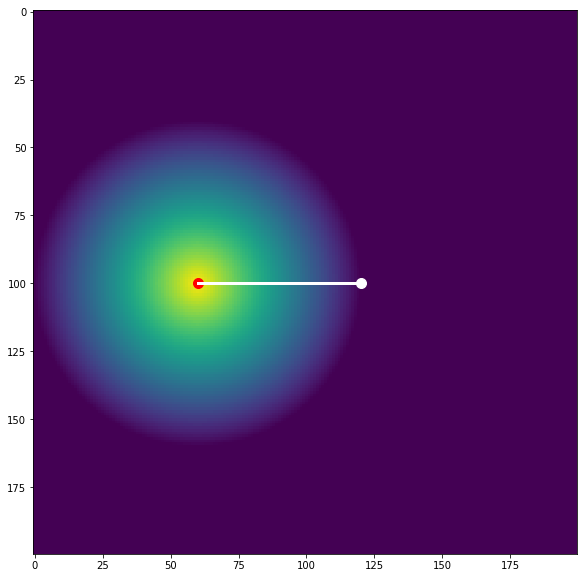

In [9]:
import numpy.linalg as la

def pcp(s, e, s_hat, e_hat):
    term1 = la.norm(s_hat - s)
    term2 = la.norm(e_hat - e)
    left = (term1 + term2) / 2
    right = la.norm(s_hat - e_hat)
    return left, right

gt = np.array(((60, 100), (120, 100)))
s_hat = gt[0]
e_hat = gt[1]
alpha = 0.5

Im = np.zeros((200, 200))
for x in range(200):
    for y in range(200):
        
        pr = np.array([
            (x, y),
            e_hat
        ])
        value, length = pcp(*pr, *gt)
        Im[y, x] = -min(value, alpha * length)

        
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(Im)


ax.plot([s_hat[0], e_hat[0]], [s_hat[1], e_hat[1]], color='white', linewidth=3)
ax.scatter(s_hat[0], s_hat[1], color='red', s=100)
ax.scatter(e_hat[0], e_hat[1], color='white', s=100)


plt.show()

In [10]:
# test pcp score
import numpy.linalg as la

def pcp(s, e, s_hat, e_hat):
    term1 = la.norm(s_hat - s)
    term2 = la.norm(e_hat - e)
    left = (term1 + term2) / 2
    right = la.norm(s_hat - e_hat)
    return left, right

# ========================================
gt = np.array(((0, 0), (10, 0)))
pr = np.array(((10, 0), (10, 0)))

alpha = 0.5
left, right = pcp(*pr, *gt)

print('is correct:', left <= alpha * right)
print('\t', (left, right))

is correct: True
	 (5.0, 10.0)


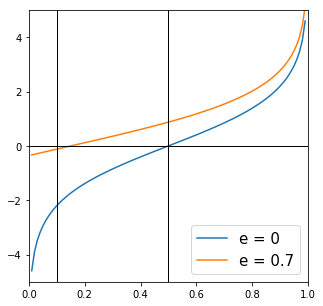

In [11]:
from math import log

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

def func(a, fact):
    return log((a + fact)/ (1 - a))

x = np.linspace(0.01, 0.99, 100)
y1 = [func(a, 0) for a in x]
y2 = [func(a, 0.7) for a in x]

ax.plot(x, y1, label='e = 0')
ax.plot(x, y2, label='e = 0.7')
ax.plot([0, 1], [0, 0], color='black', linewidth=1)
ax.plot([0.1, 0.1], [-5, 5], color='black', linewidth=1)
ax.plot([0.5, 0.5], [-5, 5], color='black', linewidth=1)
ax.set_xlim([0, 1])
ax.set_ylim([-5, 5])

plt.legend(fontsize=15)
plt.show()